In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.stats import chi2
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

In [2]:
base_str = 'z2r50205t_c'
suffix_str = 'f.fits'
fnames = [base_str + str(i) + suffix_str for i in range(0, 6)]
hdu_list = [fits.open(fname) for fname in fnames]
all_waves = [hdu_list[0][0].data[i, :] for i in [0, 4, 8, 12]]
all_exposure_means = [np.mean(hdu_list[1][0].data[i:i+4, :],
                              axis=0)
                      for i in [0, 4, 8, 12]]
all_exposure_sigmas = [np.sqrt((np.mean((hdu_list[2][0].data[i:i+4,
                                                             :])**2.0,
                                        axis=0))/4.0)
                      for i in [0, 4, 8, 12]]

In [3]:
def cross_correlate(f, g):
    return np.array([np.sum(f*np.roll(g, -(n)))
                     for n in range(0, len(f))])

corr_1 = np.argmax(cross_correlate(all_exposure_means[0],
                                   all_exposure_means[1]))
corr_2 = np.argmax(cross_correlate(all_exposure_means[0],
                                   all_exposure_means[2]))
corr_3 = np.argmax(cross_correlate(all_exposure_means[0],
                                   all_exposure_means[3]))

all_waves[1] = np.roll(all_waves[1], -(corr_1))
all_waves[2] = np.roll(all_waves[2], -(corr_2))
all_waves[3] = np.roll(all_waves[3], -(corr_3))

all_exposure_means[1] = np.roll(all_exposure_means[1], -(corr_1))
all_exposure_means[2] = np.roll(all_exposure_means[2], -(corr_2))
all_exposure_means[3] = np.roll(all_exposure_means[3], -(corr_3))

all_exposure_sigmas[1] = np.roll(all_exposure_sigmas[1], -(corr_1))
all_exposure_sigmas[2] = np.roll(all_exposure_sigmas[2], -(corr_2))
all_exposure_sigmas[3] = np.roll(all_exposure_sigmas[3], -(corr_3))

wave = all_waves[0]
flux = np.mean(np.array(all_exposure_means), axis=0)
variances = np.mean(np.array(all_exposure_sigmas)**2.0, axis=0)/4.
sigmas = np.sqrt(variances)

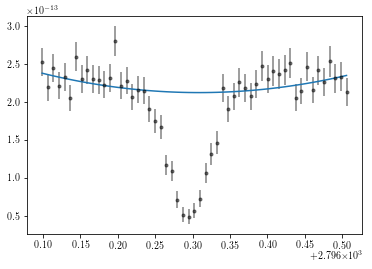

SNR in Continuum =  1.15023e-14
SNR in Line =  10.8592
Poisson-predicted SNR:  1.45705e-14


In [4]:
low1=490
high1=545
wave_1 = wave[low1:high1]
flux_1 = flux[low1:high1]
sigma_1 = sigmas[low1:high1]
cut_index = np.arange(5, 45)
fit_1 = np.polyfit(np.delete(wave_1, cut_index),
                   np.delete(flux_1, cut_index), 2)

plt.errorbar(wave_1, flux_1, yerr=sigma_1,
             alpha=0.5, fmt='.k')
plt.plot(wave_1, np.polyval(fit_1, wave_1))
plt.show()

signal_continuum = np.var(np.delete(flux_1, cut_index))
noise_continuum = np.mean(np.delete(sigma_1, cut_index))
noise_line = np.mean(sigma_1[cut_index])
signal_line = np.mean(np.delete(flux_1, cut_index)) - np.min(flux_1)

print('SNR in Continuum = ',
      signal_continuum/noise_continuum)
print('SNR in Line = ',
      signal_line/noise_line)
print('Poisson-predicted SNR: ', np.sqrt(signal_continuum))

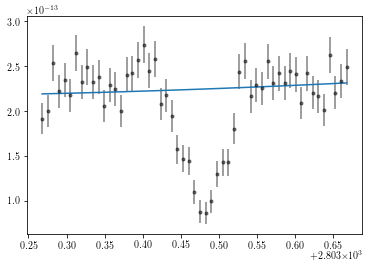

SNR in Continuum =  2.16693e-14
SNR in Line =  7.84115
Poisson-predicted SNR:  2.01523e-14


In [5]:
low2=1450
high2=1505
wave_2 = wave[low2:high2]
flux_2 = flux[low2:high2]
sigma_2 = sigmas[low2:high2]

fit_2 = np.polyfit(np.delete(wave_2, cut_index),
                   np.delete(flux_2, cut_index), 2)
plt.errorbar(wave_2, flux_2, yerr=sigma_2,
             alpha=0.5, fmt='.k')
plt.plot(wave_2, np.polyval(fit_2, wave_2))
plt.show()

signal_continuum = np.var(np.delete(flux_2, cut_index))
noise_continuum = np.mean(np.delete(sigma_2, cut_index))
noise_line = np.mean(sigma_2[cut_index])
signal_line = np.mean(np.delete(flux_2, cut_index)) - np.min(flux_2)

print('SNR in Continuum = ',
      signal_continuum/noise_continuum)
print('SNR in Line = ',
      signal_line/noise_line)
print('Poisson-predicted SNR: ', np.sqrt(signal_continuum))

In [6]:
normflux_1 = flux_1/np.polyval(fit_1, wave_1)
normsigma_1 = sigma_1/np.polyval(fit_1, wave_1)

normflux_2 = flux_2/np.polyval(fit_2, wave_2)
normsigma_2 = sigma_2/np.polyval(fit_2, wave_2)

In [7]:
def wave2vel(wave, clambda):
    dellambda = wave - clambda
    lightvel = 299792.458
    vel = dellambda*lightvel/clambda
    return vel


def vel2wave(vel, clambda):
    lightvel = 299792.458
    wave = clambda*(1.0 + vel/lightvel)
    return wave


def model_gaussian(x, amp, width, mean, offset):
    exp_factor = -((x - mean)**2.0)/(2.0*(width**2.0))
    return offset + amp*np.exp(exp_factor)


def fit_chi2(init_guess,
             x, y, yerr,
             model_func=model_gaussian):
    popt, pcov = curve_fit(model_func, x, y,
                          p0=init_guess, sigma=yerr,
                          absolute_sigma=True,
                          method='lm')
    return popt, pcov

clambda_1 = 2796.352
clambda_2 = 2803.531

osc_strength_1 = 0.6123
osc_strength_2 = 0.3054

vel_1 = wave2vel(wave_1, clambda_1)
vel_2 = wave2vel(wave_2, clambda_2)
label_strs = ['Amplitude', 'Line Width', 'Line Position']
unit_strs = [' ', ' Angstroms', ' Angstroms']
unit_strs_v = [' ', 'km/s', 'km/s']

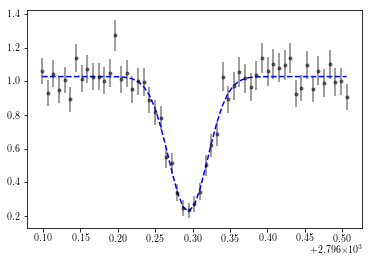

Amplitude  =  -0.802808026035  +/-  0.027107065214  
Line Width  =  0.0260818203686  +/-  0.00137147718823  Angstroms
Line Position  =  2796.29408394  +/-  0.00116285572382  Angstroms


In [8]:
init_1 = [-0.8, 0.03, 2796.3, 1.0]
popt_1, pcov_1 = fit_chi2(init_1, wave_1, normflux_1, normsigma_1)

amp_1 = popt_1[0]
width_1 = popt_1[1]
mean_1 = popt_1[2]
offset_1 = popt_1[3]

plt.errorbar(wave_1, normflux_1, yerr=normsigma_1,
             alpha=0.5, fmt='.k')
plt.plot(wave_1,
         model_gaussian(wave_1,
                        amp_1, width_1, mean_1, offset_1),
         '--b')
plt.show()
uncertainties_1 = [np.sqrt(pcov_1[i, i]) for i in range(0, 4)]
for i in range(0, 3):
    print(label_strs[i],
          ' = ', str(popt_1[i]), ' +/- ',
          str(uncertainties_1[i]), unit_strs[i])

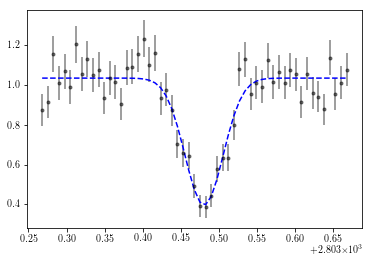

Amplitude  =  -0.637258107739  +/-  0.0315587749567  
Line Width  =  0.0251161456843  +/-  0.0017670797029  Angstroms
Line Position  =  2803.48058994  +/-  0.00155993777898  Angstroms


In [9]:
init_2 = [-0.6, 0.03, 2803.45, 1.0]
popt_2, pcov_2 = fit_chi2(init_2, wave_2, normflux_2, normsigma_2)

amp_2 = popt_2[0]
width_2 = popt_2[1]
mean_2 = popt_2[2]
offset_2 = popt_2[3]

plt.errorbar(wave_2, normflux_2, yerr=normsigma_2,
             alpha=0.5, fmt='.k')
plt.plot(wave_2,
         model_gaussian(wave_2,
                        amp_2, width_2, mean_2, offset_2),
         '--b')
plt.show()
uncertainties_2 = [np.sqrt(pcov_2[i, i]) for i in range(0, 4)]
for i in range(0, 3):
    print(label_strs[i],
          ' = ', str(popt_2[i]), ' +/- ',
          str(uncertainties_2[i]), unit_strs[i])

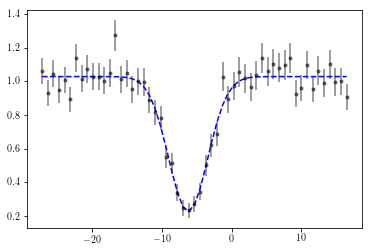

Amplitude  =  -0.80280817807  +/-  0.0271071540671  
Line Width  =  2.796187576  +/-  0.147040691426 km/s
Line Position  =  -6.20909089755  +/-  0.124671926638 km/s


In [10]:
init_1v = [-0.8, 3.0, -9, 1.0]
popt_1v, pcov_1v = fit_chi2(init_1v, vel_1, normflux_1, normsigma_1)

amp_1v = popt_1v[0]
width_1v = popt_1v[1]
mean_1v = popt_1v[2]
offset_1v = popt_1v[3]

plt.errorbar(vel_1, normflux_1, yerr=normsigma_1,
             alpha=0.5, fmt='.k')
plt.plot(vel_1,
         model_gaussian(vel_1,
                        amp_1v, width_1v, mean_1v, offset_1v),
         '--b')
plt.show()
uncertainties_1v = [np.sqrt(pcov_1v[i, i]) for i in range(0, 4)]
for i in range(0, 3):
    print(label_strs[i],
          ' = ', str(popt_1v[i]), ' +/- ',
          str(uncertainties_1v[i]), unit_strs_v[i])

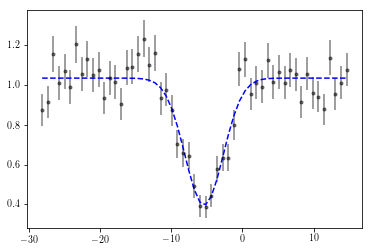

Amplitude  =  -0.637264248838  +/-  0.0315569389818  
Line Width  =  2.68565750565  +/-  0.188997785569 km/s
Line Position  =  -5.39055241621  +/-  0.166839399168 km/s


In [11]:
init_2v = [-0.8, 3.0, -7, 1.0]
popt_2v, pcov_2v = fit_chi2(init_2v, vel_2, normflux_2, normsigma_2)

amp_2v = popt_2v[0]
width_2v = popt_2v[1]
mean_2v = popt_2v[2]
offset_2v = popt_2v[3]

plt.errorbar(vel_2, normflux_2, yerr=normsigma_2,
             alpha=0.5, fmt='.k')
plt.plot(vel_2,
         model_gaussian(vel_2,
                        amp_2v, width_2v, mean_2v, offset_2v),
         '--b')
plt.show()
uncertainties_2v = [np.sqrt(pcov_2v[i, i]) for i in range(0, 4)]
for i in range(0, 3):
    print(label_strs[i],
          ' = ', str(popt_2v[i]), ' +/- ',
          str(uncertainties_2v[i]), unit_strs_v[i])

In [12]:
chi2_lines = (((mean_1v - mean_2v)**2.0)/
              ((uncertainties_1v[2]**2.0
                + uncertainties_2v[2]**2.0)))
print('PTE = ', chi2.sf(chi2_lines, 2))

PTE =  0.000442626261109


FWHM resolution = 3.7 pixels (we are resolved)

In [13]:
ew_1 = np.sum(normflux_1[cut_index][10:-8]-1.0)*np.mean(np.diff(wave_1[cut_index][10:-8]))
ew_2 = np.sum(normflux_2[cut_index][14:-8]-1.0)*np.mean(np.diff(wave_2[cut_index][14:-8]))


term_1_1 = ((ew_1/amp_1)*(uncertainties_1[0]))**2.0
term_1_2 = ((ew_2/amp_2)*(uncertainties_2[0]))**2.0

term_2_1 = ((amp_1/(width_1**3.0))*0.000044474*uncertainties_1[1])**2.0
term_2_2 = ((amp_2/(width_2**3.0))*0.0000391661*uncertainties_2[1])**2.0

ew_1_analytic = np.sqrt(term_1_1 + term_2_1)
ew_2_analytic = np.sqrt(term_1_2 + term_2_2)

wave_del = np.delete(wave, np.append(cut_index+low1, cut_index+low2))
flux_del = np.delete(flux, np.append(cut_index+low1, cut_index+low2))
normflux_del = flux_del/(np.polyval(np.polyfit(wave_del, flux_del, 2),
                                   wave_del))


ew_1_sample = np.std([np.sum(normflux_del[i:i+18]*
                             np.mean(np.diff(wave_del[i:i+18])))
                       for i in [0, 200, 300, 400]])

ew_2_sample = np.std([np.sum(normflux_del[i:i+22]*
                             np.mean(np.diff(wave_del[i:i+22])))
                       for i in [0, 200, 300, 400]])

print('EW for 2796: ', ew_1, ' +/-',
      ew_1_analytic,
      ' (Analytic) ', 'or ', ew_1_sample, ' (Sampling)')

print('EW for 2803: ', ew_2, ' +/-',
      ew_2_analytic,
      ' (Analytic) ', 'or ', ew_2_sample, ' (Sampling)')

EW for 2796:  -0.0470837726235  +/- 0.00318504117203  (Analytic)  or  0.00216907090728  (Sampling)
EW for 2803:  -0.0324514550265  +/- 0.00321429995855  (Analytic)  or  0.00196068212832  (Sampling)


Analytic integral 1 EW = -0.052485519606

Analytic integral 2 EW = -0.040119622083 